<a href="https://colab.research.google.com/github/Cl8D/SSUML/blob/main/Project%204%20-%20Style%20Transfer%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import PIL
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [ ]:
# GPU 장치 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
'''
#원하는 사진을 직접 업로드할 수 있도록
from google.colab import files
uploaded = files.upload()
uploaded = files.upload()
uploaded = files.upload()
uploaded = files.upload()
'''

'\n#원하는 사진을 직접 업로드할 수 있도록\nfrom google.colab import files\nuploaded = files.upload()\nuploaded = files.upload()\nuploaded = files.upload()\nuploaded = files.upload()\n'

In [ ]:
# 이미지를 불러와 다운받아 텐서(Tensor) 객체로 변환하는 함수
def image_loader(img_path, imsize):
    loader = transforms.Compose([
        transforms.Resize(imsize), # 이미지의 크기를 변경
        transforms.ToTensor() # torch.Tensor 형식으로 변경 [0, 255] → [0, 1]
    ])
    image = Image.open(img_path)
    # 네트워크 입력에 들어갈 이미지에 배치 목적의 차원(dimension) 추가
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float) # GPU로 올리기

In [ ]:
# torch.Tensor 형태의 이미지를 화면에 출력하는 함수
def imshow(tensor, tittle):
    # matplotlib는 CPU 기반이므로 CPU로 옮기기
    image = tensor.cpu().clone()
    # torch.Tensor에서 사용되는 배치 목적의 차원(dimension) 제거
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # plot이 업데이트될 동안 잠시 멈추기

In [ ]:
%cd ./drive/MyDrive

/content/drive/MyDrive


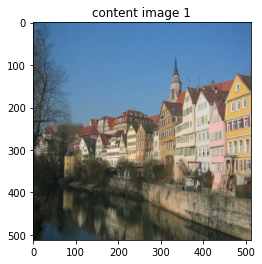

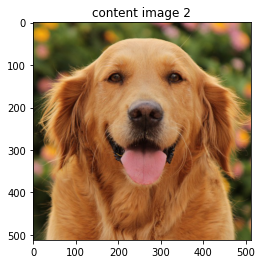

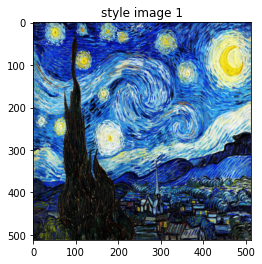

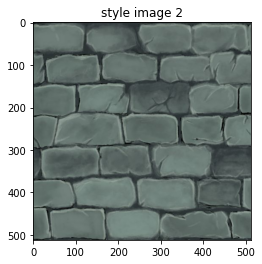

In [ ]:
unloader = transforms.ToPILImage()  # PIL image로 다시 재변환하기
plt.ion()

content1 = image_loader('content_img_1.jpg', (512, 512)) #(512, 512)로 resize
content2 = image_loader('content_img_2.jpg', (512, 512))
style1 = image_loader('style_img_1.jpg', (512, 512))
style2 = image_loader('style_img_2.jpg', (512, 512))

plt.figure()
imshow(content1, title = 'content image 1')
plt.figure()
imshow(content2, title = 'content image 2')
plt.figure()
imshow(style1, title = 'style image 1')
plt.figure()
imshow(style2, title = 'style image 2')

# **Content Loss**

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        # mse loss를 사용한다
        self.loss = F.mse_loss(input, self.target)
        return input

# **Style Loss**

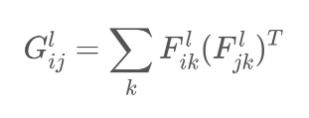

In [ ]:
def gram_matrix(input):
    # a는 배치 크기, b는 특징 맵의 개수, (c, d)는 특징 맵의 차원을 의미
    a, b, c, d = input.size() #batch size, channel size, height, width
    
    # 논문에서는 i = 특징 맵의 개수, j = 각 위치(position)
    # 특정 위치에 접근하는 형태로 표현하기. (행렬로 변환)
    # 행은 batch size * channel size, 열에는 각각이ㅡ 위치에 대한 activation 값
    features = input.view(a * b, c * d) 
    
    # 행렬 곱으로 한 번에 Gram 내적 계산 가능
    # 서로 다른 2개의 feature 간의 상관관계를 구할 수 있게 된다.
    G = torch.mm(features, features.t())
    # Normalize 목적으로 값 나누기
    return G.div(a * b * c * d)

In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

# **Importing Model**

In [ ]:
# 뉴럴 네트워크 모델을 불러옵니다.(VGG19 사용)
# 이미지를 넣은 다음에 각 레이어에 대한 output feature 값을 얻기
cnn = models.vgg19(pretrained=True).features.to(device).eval()
print(cnn)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPo

In [ ]:
# 입력 정규화(Normalization)를 위한 초기화
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# 입력 이미지를 normalize하는 모듈을 만들어서 쉽게 nn.sequential에 넣도록 한다
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # mean, std를 [Cx1x1]로 만들어서 이미지 tensor와 직접적으로 work 할 수 있도록 한다.
        # (Image tensor의 크기가 BxCxHxW니까)
        self.mean = mean.clone().view(-1, 1, 1) 
        self.std = std.clone().view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [ ]:
# loss를 계산하기 위해 필요한 depth
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    #normalization 하기
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0 
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

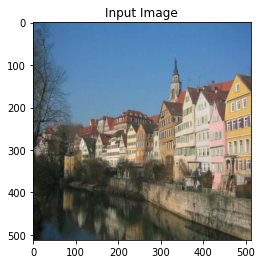

In [ ]:
input_img = content1.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [ ]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 254.780930 Content Loss: 51.613518

run [100]:
Style Loss : 76.569489 Content Loss: 50.364258

run [150]:
Style Loss : 40.857193 Content Loss: 47.717918

run [200]:
Style Loss : 27.693607 Content Loss: 44.299084

run [250]:
Style Loss : 22.012352 Content Loss: 40.665115

run [300]:
Style Loss : 17.075031 Content Loss: 37.677227



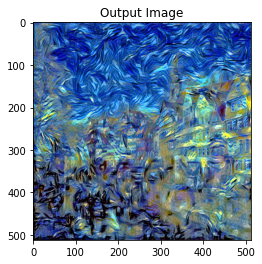

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content1, style1, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 8.076438 Content Loss: 14.143436

run [100]:
Style Loss : 2.331491 Content Loss: 10.881563

run [150]:
Style Loss : 1.343902 Content Loss: 9.004661

run [200]:
Style Loss : 0.950222 Content Loss: 7.798541

run [250]:
Style Loss : 0.726809 Content Loss: 6.977281

run [300]:
Style Loss : 0.615963 Content Loss: 6.351886



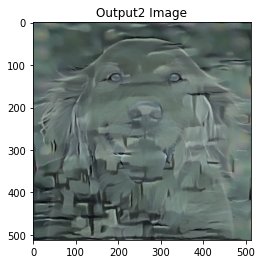

In [ ]:
output2 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content2, style2, input_img)

plt.figure()
imshow(output2, title='Output2 Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()